# Running FLiES for an ECOSTRESS Scene

This is an example of running the artificial neural network emulator of the Forest Light Environmental Simulator (FLiES) corresponding to an ECOsystem Spaceborne Thermal Radiometer Experiment on Space Station (ECOSTRESS) scene.

In [1]:
from os.path import join
from datetime import datetime, date, time
from dateutil import parser
import rasters as rt
from geos5fp import GEOS5FP
from koppengeiger import load_koppen_geiger
from solar_apparent_time import UTC_to_solar
import sun_angles
from FLiESLUT import process_FLiES_LUT_raster
from matplotlib.colors import LinearSegmentedColormap
from MCD12C1_2019_v006 import load_MCD12C1_IGBP
import logging
logging.disable(logging.CRITICAL)

Here's an example ECOSTRESS surface temperature scene.

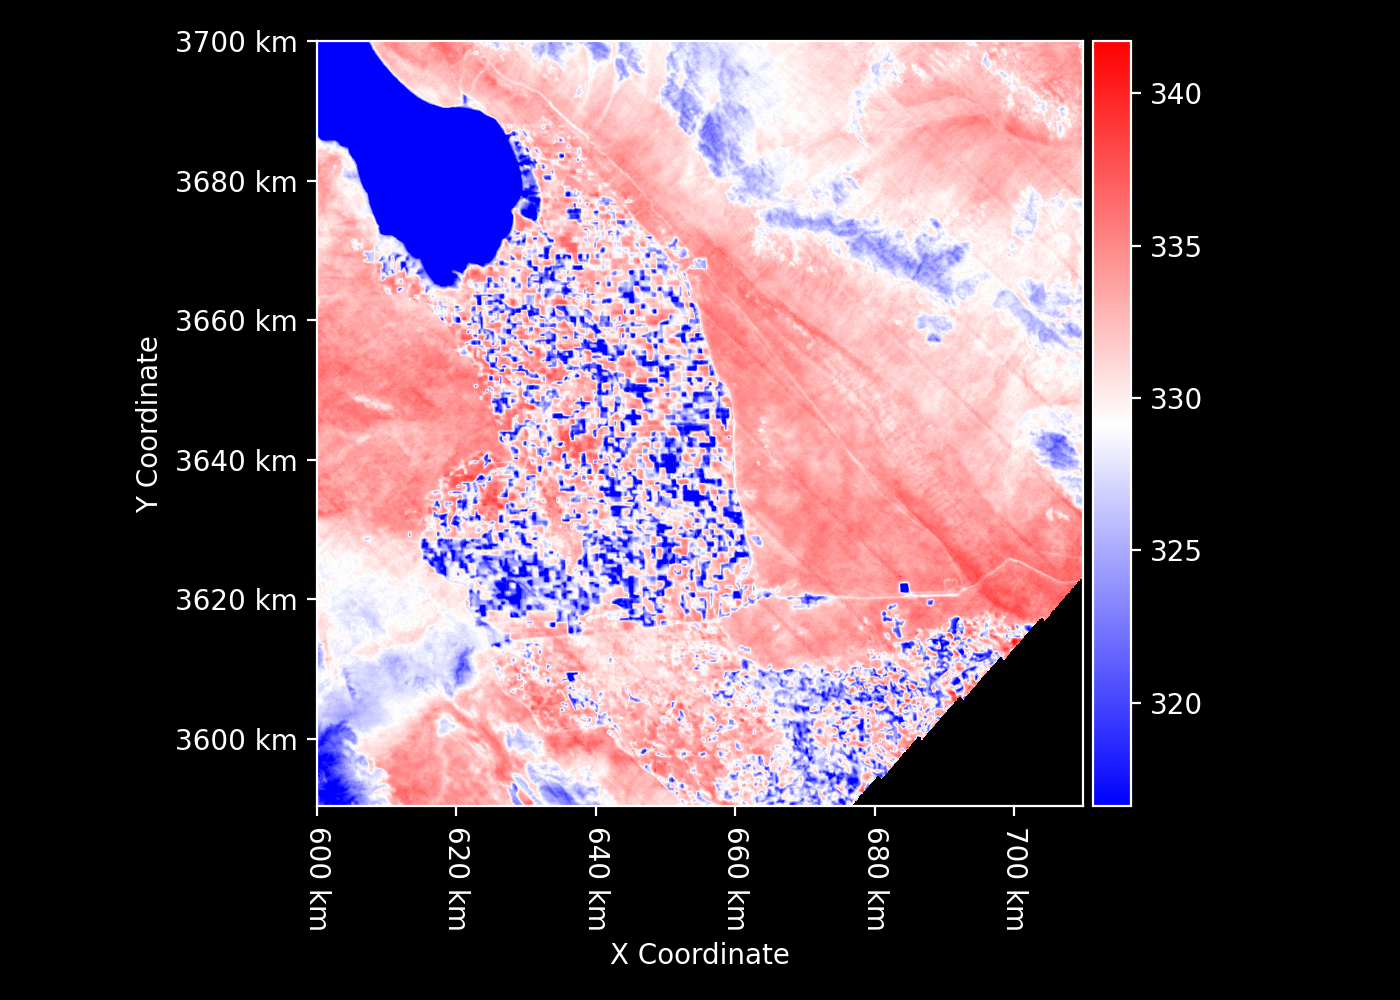

In [2]:
ST_filename = "ECOv002_L2T_LSTE_34366_004_11SPS_20240728T204025_0712_01_LST.tif"
ST_cmap = "bwr"
ST = rt.Raster.open(ST_filename, cmap=ST_cmap)
ST

Let's get the acquisition time of the scene.

In [3]:
time_UTC = parser.parse(ST_filename.split("_")[6])
longitude = ST.geometry.centroid_latlon.x
latitude = ST.geometry.centroid_latlon.y
time_solar = UTC_to_solar(time_UTC, longitude)
doy_solar = time_solar.timetuple().tm_yday
hour_of_day_solar = time_solar.hour + time_solar.minute / 60 + time_solar.second / 3600
print(f"{time_UTC:%Y-%m-%d %H:%M:%S} UTC")
print(f"{time_solar:%Y-%m-%d %H:%M:%S} solar apparent time at longitude {longitude}")
print(f"day of year {doy_solar} at longitude {longitude}")
print(f"hour of day {hour_of_day_solar} at longitude {longitude}")


2024-07-28 20:40:25 UTC
2024-07-28 12:59:02 solar apparent time at longitude -115.3433725031462
day of year 210 at longitude -115.3433725031462
hour of day 12.983888888888888 at longitude -115.3433725031462


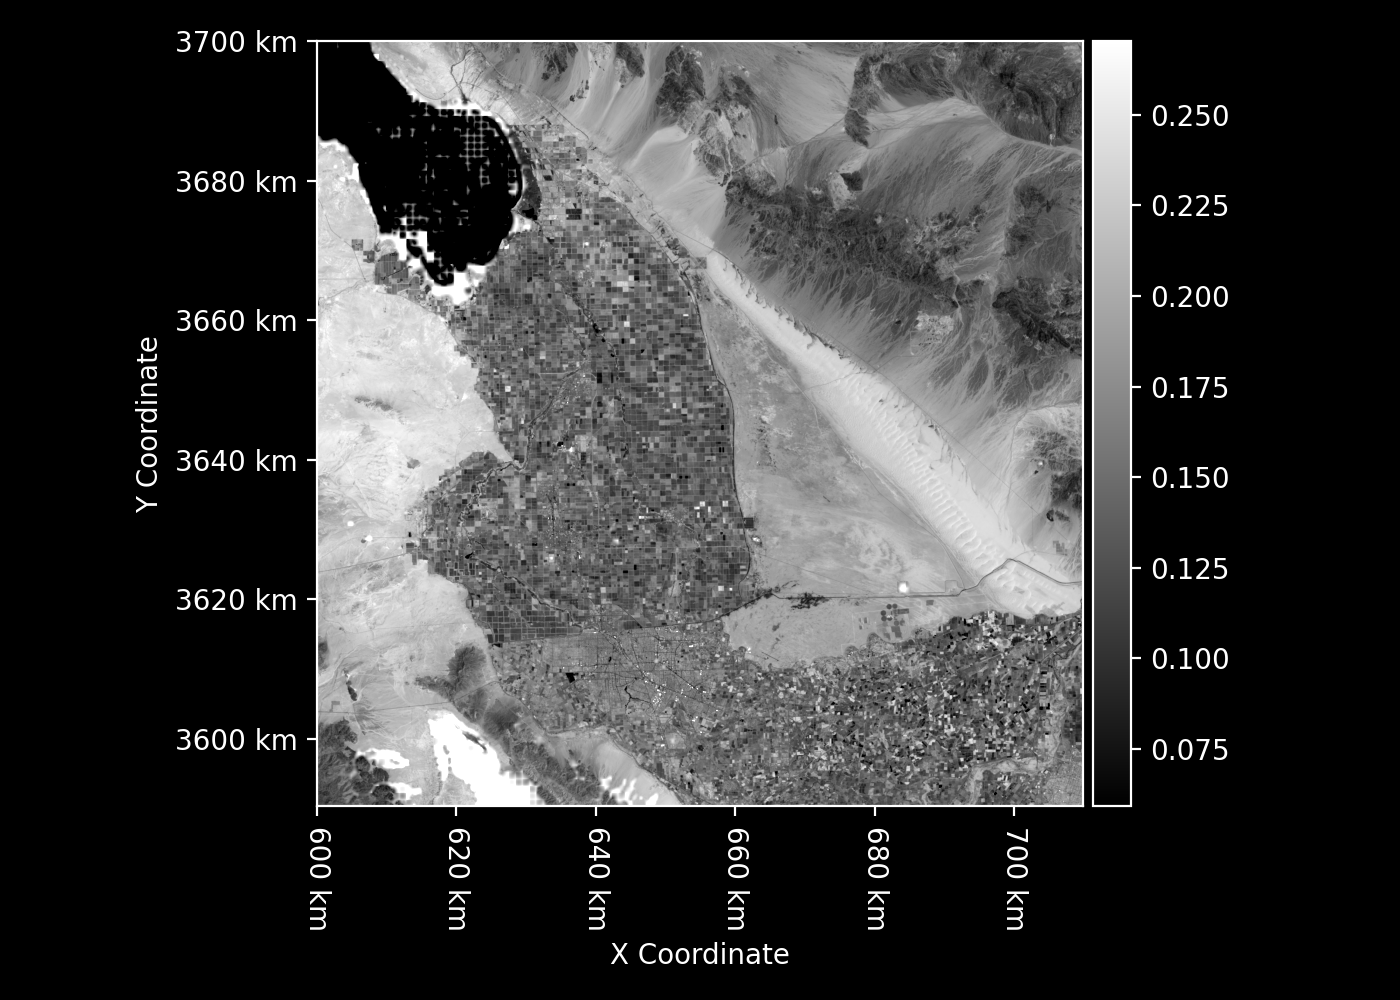

In [4]:
albedo_filename = "ECOv002_L2T_STARS_11SPS_20240728_0712_01_albedo.tif"
albedo_cmap = LinearSegmentedColormap.from_list(name="albedo", colors=["black", "white"])
albedo = rt.Raster.open(albedo_filename, cmap=albedo_cmap)
albedo

We'll use the `geos5fp` package to generate rasters of aerosol optical thickness (AOT) and cloud optical thickness (COT).

In [5]:
geos5fp = GEOS5FP(working_directory=join("~", "data", "GEOS5FP"))

Download AOT from GEOS-5 FP.

In [6]:
%%capture
AOT = geos5fp.AOT(time_UTC=time_UTC, geometry=albedo.geometry)

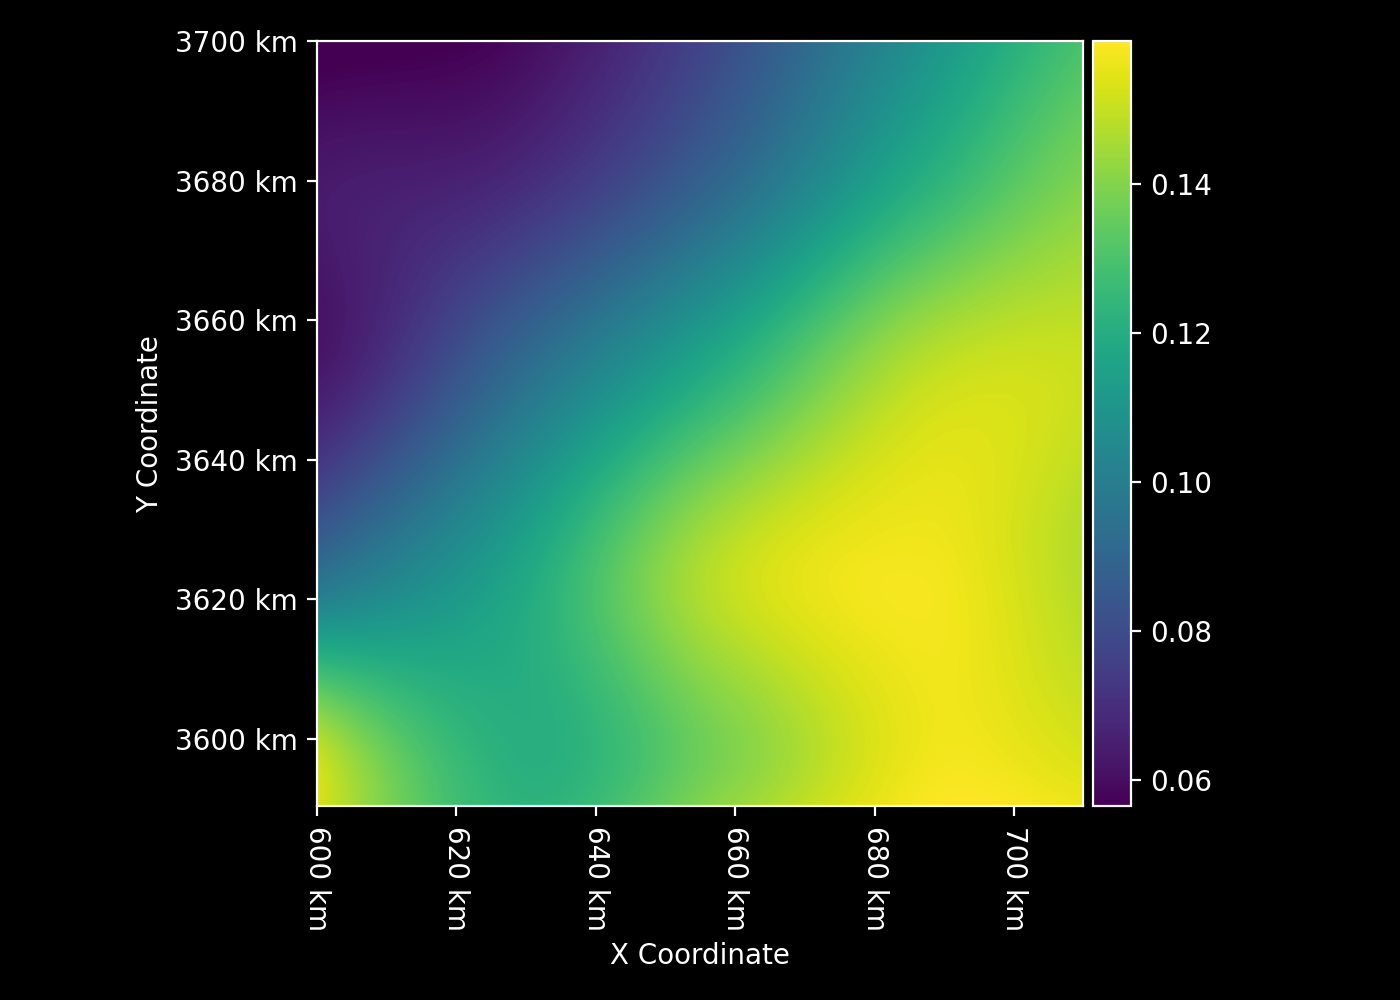

In [7]:
AOT.cmap = "viridis"
AOT

Download COT from GEOS-5 FP.

In [8]:
%%capture
COT = geos5fp.COT(time_UTC=time_UTC, geometry=albedo.geometry)

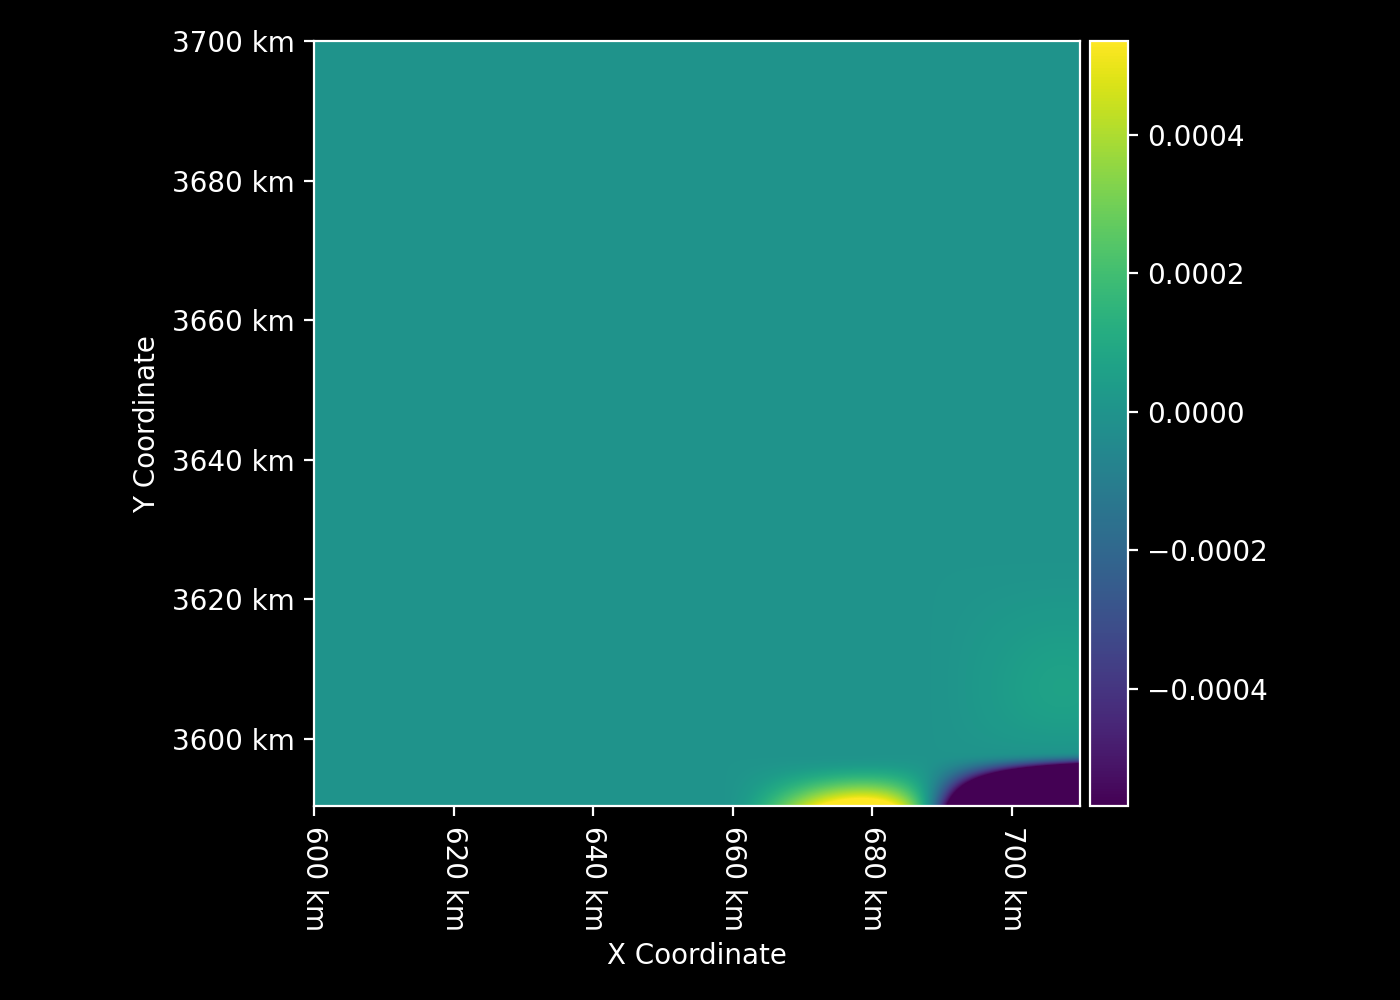

In [9]:
COT.cmap = "viridis"
COT

Load the Köppen–Geiger climate classification from the `koppengeiger` package.

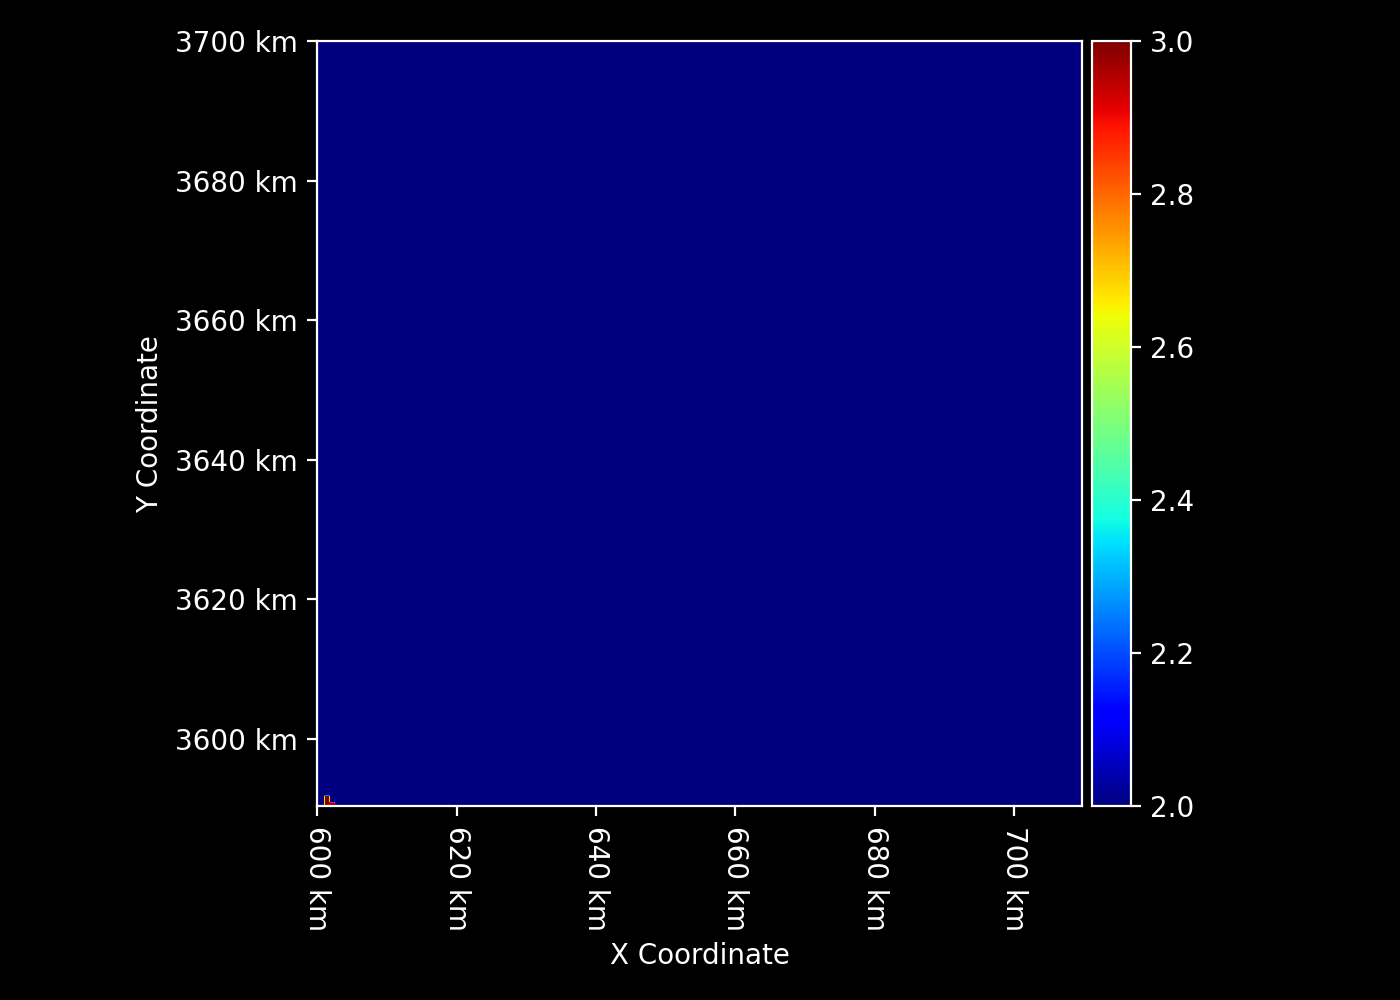

In [10]:
kg = load_koppen_geiger(albedo.geometry)
kg

In [11]:
day_angle_rad = sun_angles.day_angle_rad_from_DOY(doy_solar)
solar_dec_deg = sun_angles.solar_dec_deg_from_day_angle_rad(day_angle_rad)
SZA_deg = sun_angles.SZA_deg_from_lat_dec_hour(ST.geometry.lat, solar_dec_deg, hour_of_day_solar)
SZA_deg

array([[19.58331727, 19.58331273, 19.58330818, ..., 19.57232504,
        19.57231554, 19.57230603],
       [19.58287844, 19.5828739 , 19.58286935, ..., 19.57188673,
        19.57187722, 19.57186772],
       [19.58243962, 19.58243508, 19.58243053, ..., 19.57144842,
        19.57143892, 19.57142941],
       ...,
       [18.90930225, 18.90929804, 18.90929382, ..., 18.89911795,
        18.89910914, 18.89910033],
       [18.90888002, 18.90887581, 18.9088716 , ..., 18.89869624,
        18.89868743, 18.89867863],
       [18.90845781, 18.9084536 , 18.90844938, ..., 18.89827454,
        18.89826574, 18.89825693]])

/opt/homebrew/Caskroom/mambaforge/base/envs/FLiESLUT/lib/python3.11/site-packages/rasters/raster.py:1663: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed in 3.10.  To suppress this warning, explicitly call plt.close('all') first.
  plt.switch_backend(prior_backend)


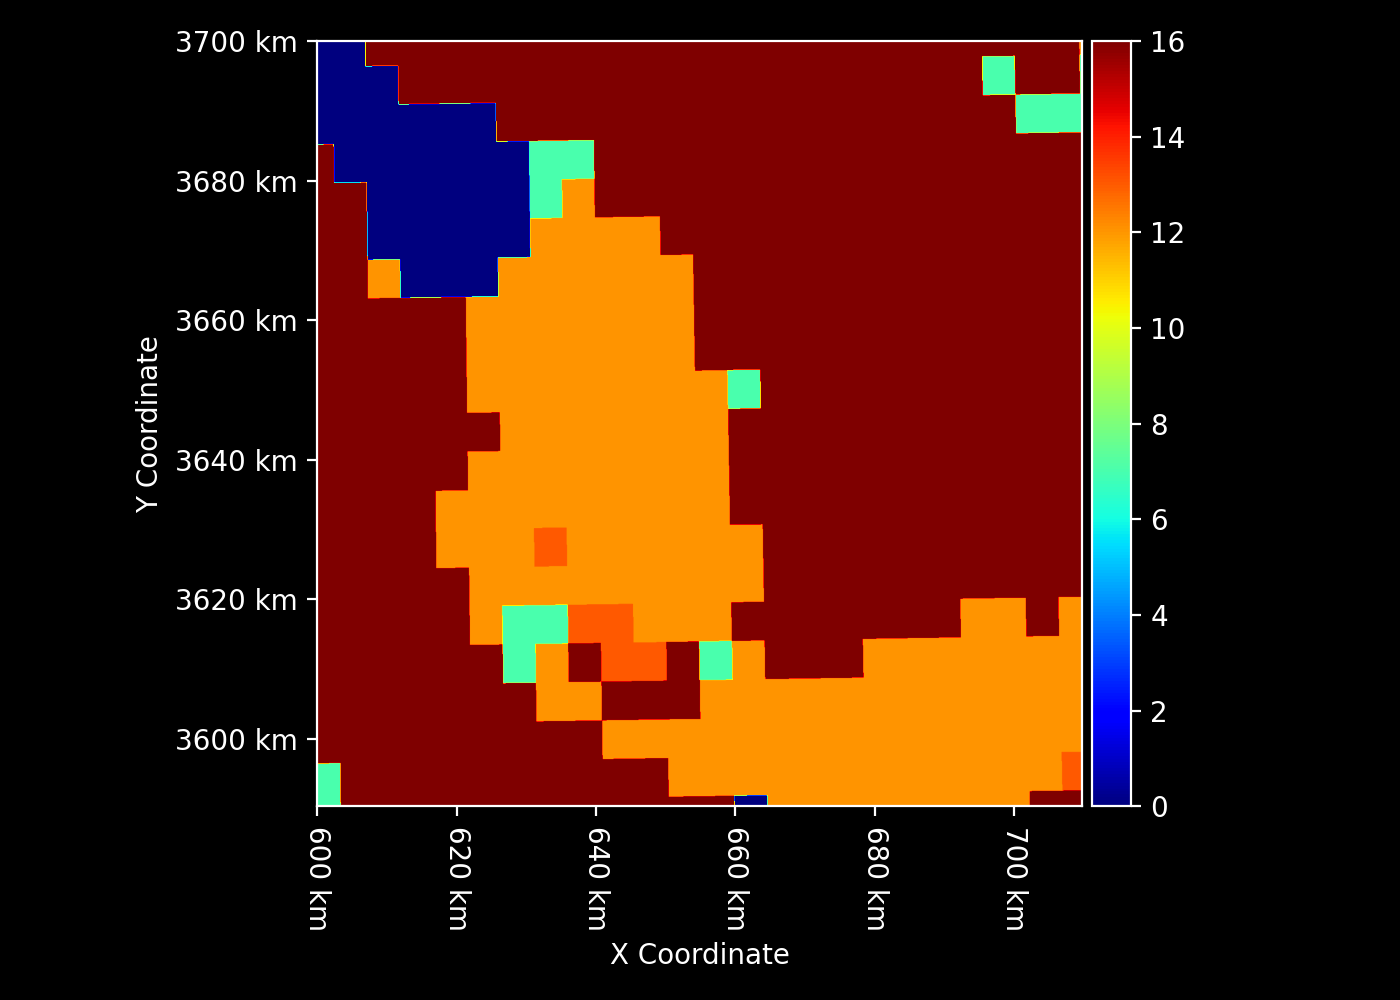

In [12]:
IGBP = load_MCD12C1_IGBP(albedo.geometry)
IGBP

/opt/homebrew/Caskroom/mambaforge/base/envs/FLiESLUT/lib/python3.11/site-packages/pyproj/transformer.py:817: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/opt/homebrew/Caskroom/mambaforge/base/envs/FLiESLUT/lib/python3.11/site-packages/rasters/raster.py:1663: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed in 3.10.  To suppress this warning, explicitly call plt.close('all') first.
  plt.switch_backend(prior_backend)


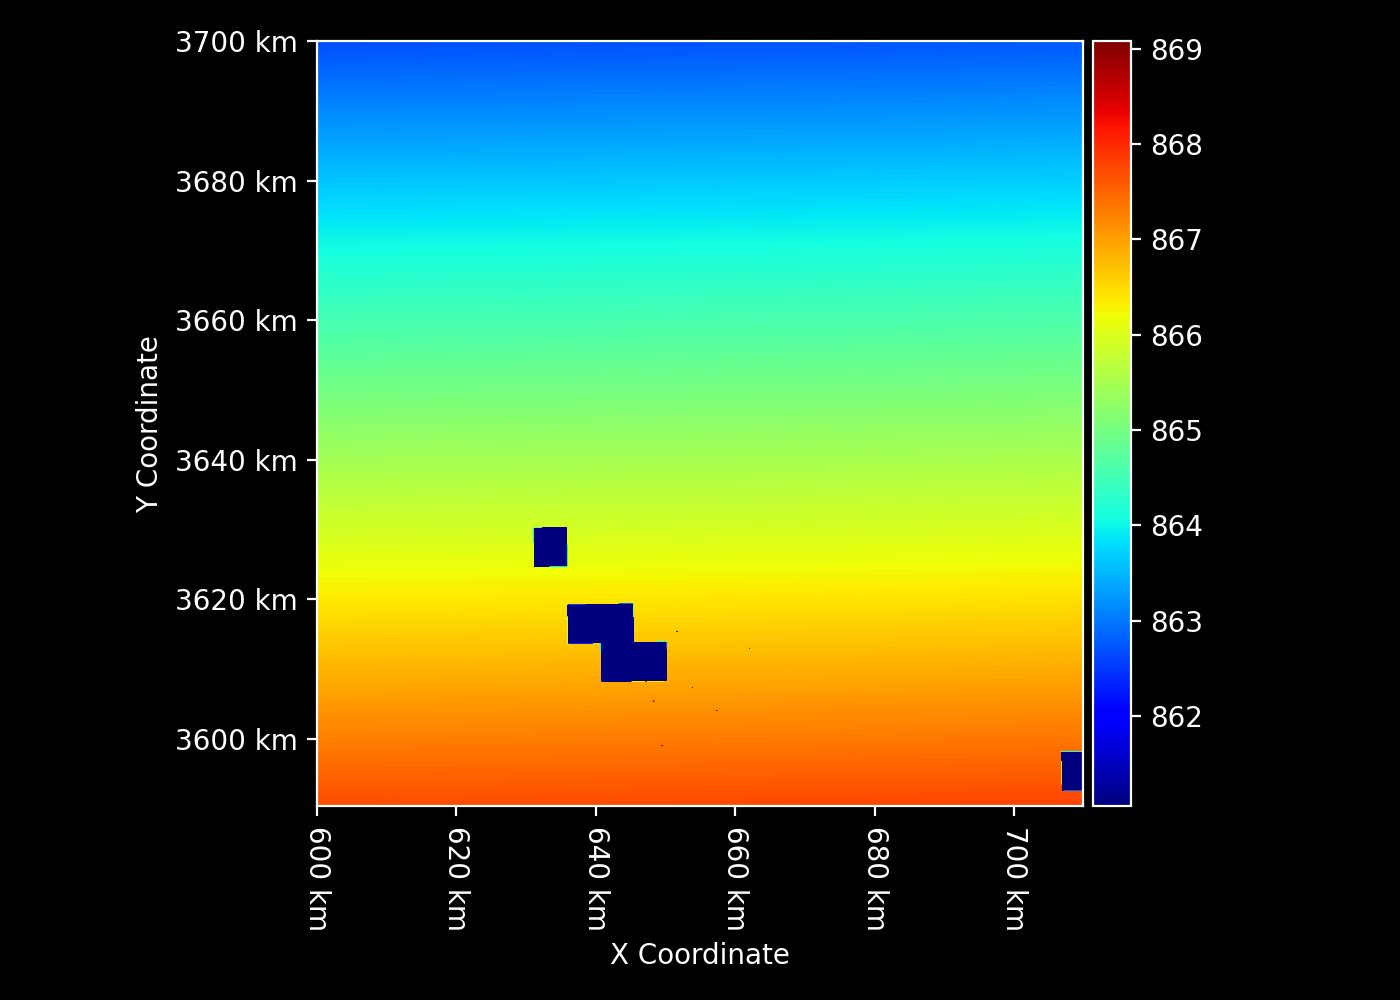

In [13]:
SWin = process_FLiES_LUT_raster(
    geometry=albedo.geometry,
    time_UTC=time_UTC,
    albedo=albedo,
    COT=COT,
    AOT=AOT,
    koppen_geiger=kg,
    SZA=SZA_deg,
    GEOS5FP_connection=geos5fp
)

SWin